In [11]:
# Listing 1: Data loading and transforms
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_split_all = datasets.MNIST('./data', train=True, download=True, transform=transform)

N = 1500
indices = torch.randperm(len(train_split_all))[:N]
train_split = Subset(train_split_all, indices)
test_split = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_split, shuffle=True, batch_size=50, num_workers=1)
test_dataloader = DataLoader(test_split, shuffle=False, batch_size=50, num_workers=1)


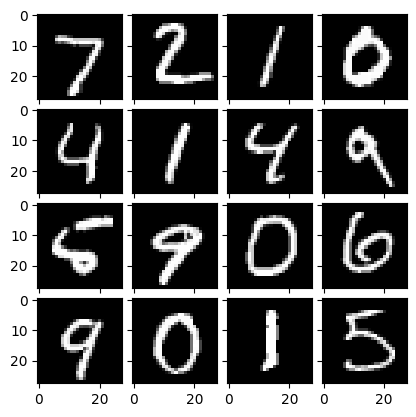

In [12]:
# Listing 2: Visualizing MNIST samples
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

sampler = enumerate(test_dataloader)
batch_idx, (x, y) = next(sampler)

images = [x[i].squeeze().numpy() for i in range(16)]

fig = plt.figure()
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
for axis, image in zip(grid, images):
    axis.imshow(image, cmap='gray')
plt.show()


In [13]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=32, output_size=10):
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, output_size)
        self.act1 = nn.Tanh()
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h1 = self.act1(self.layer_1(x))
        out = self.act2(self.layer_2(h1))
        return out

In [14]:
# Listing 4: Train 6 models and save
import torch.optim as optim
from torch.nn.functional import one_hot
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 50
lr = 1.0

hidden_sizes = [8, 16, 32, 64, 128, 256]

os.makedirs("plots", exist_ok=True)

def train(model, optimizer, dataloader):
    model.train()
    losses, accs = [], []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = mse_loss(pred, one_hot(y, num_classes=10).float())
        loss.backward()
        optimizer.step()
        acc = (pred.argmax(dim=-1) == y).float().mean()
        losses.append(loss.detach().cpu())
        accs.append(acc.cpu())
    return torch.stack(losses).mean(), torch.stack(accs).mean()

def test(model, dataloader):
    model.eval()
    losses, accs = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = mse_loss(pred, one_hot(y, num_classes=10).float())
            acc = (pred.argmax(dim=-1) == y).float().mean()
            losses.append(loss.cpu())
            accs.append(acc.cpu())
    return torch.stack(losses).mean(), torch.stack(accs).mean()

mse_loss = nn.MSELoss()

for h in hidden_sizes:
    print(f"\nTraining model with hidden size = {h}")
    model = MLP(hidden_size=h).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train(model, optimizer, train_dataloader)
        te_loss, te_acc = test(model, test_dataloader)

        print(f"Epoch {epoch}: Train Loss={tr_loss:.2f}, Train Acc={tr_acc:.2f}, Test Loss={te_loss:.2f}, Test Acc={te_acc:.2f}")
        train_losses.append(tr_loss.item())
        test_losses.append(te_loss.item())
        train_accs.append(tr_acc.item())
        test_accs.append(te_acc.item())

    torch.save(model.state_dict(), f'mlp_hidden_{h}.pth')

    # Save plots
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss: Hidden size: {h}')
    plt.legend()
    plt.savefig(f'plots/loss_hidden_{h}.png')
    plt.close()

    plt.figure()
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy: Hidden size: {h}')
    plt.legend()
    plt.savefig(f'plots/acc_hidden_{h}.png')
    plt.close()



Training model with hidden size = 8
Epoch 0: Train Loss=0.14, Train Acc=0.10, Test Loss=0.09, Test Acc=0.22
Epoch 1: Train Loss=0.09, Train Acc=0.29, Test Loss=0.09, Test Acc=0.29
Epoch 2: Train Loss=0.09, Train Acc=0.30, Test Loss=0.09, Test Acc=0.28
Epoch 3: Train Loss=0.09, Train Acc=0.29, Test Loss=0.09, Test Acc=0.28
Epoch 4: Train Loss=0.08, Train Acc=0.30, Test Loss=0.08, Test Acc=0.29
Epoch 5: Train Loss=0.08, Train Acc=0.31, Test Loss=0.08, Test Acc=0.29
Epoch 6: Train Loss=0.08, Train Acc=0.32, Test Loss=0.08, Test Acc=0.30
Epoch 7: Train Loss=0.08, Train Acc=0.33, Test Loss=0.08, Test Acc=0.31
Epoch 8: Train Loss=0.08, Train Acc=0.34, Test Loss=0.08, Test Acc=0.33
Epoch 9: Train Loss=0.08, Train Acc=0.36, Test Loss=0.08, Test Acc=0.34
Epoch 10: Train Loss=0.08, Train Acc=0.37, Test Loss=0.08, Test Acc=0.36
Epoch 11: Train Loss=0.08, Train Acc=0.39, Test Loss=0.08, Test Acc=0.37
Epoch 12: Train Loss=0.07, Train Acc=0.39, Test Loss=0.08, Test Acc=0.37
Epoch 13: Train Loss=0.0

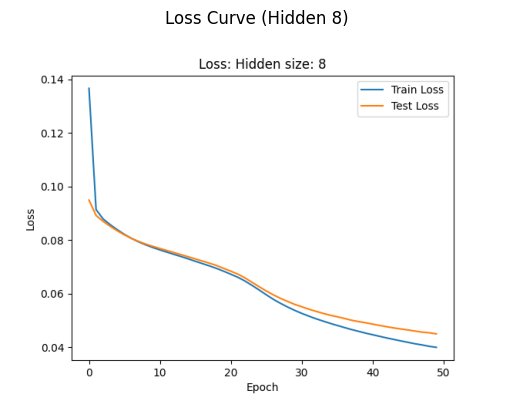

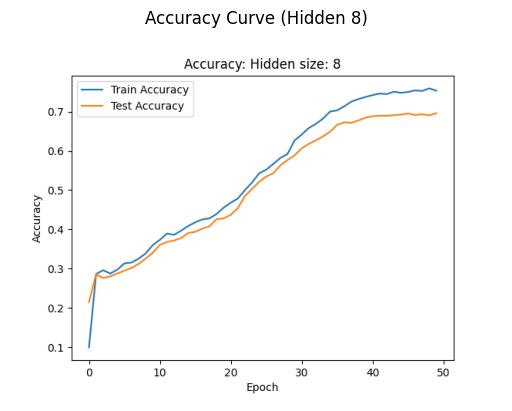

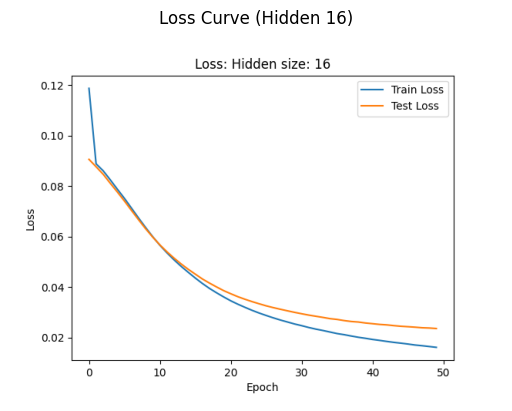

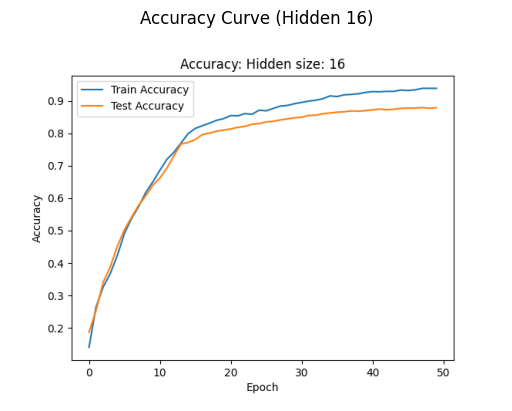

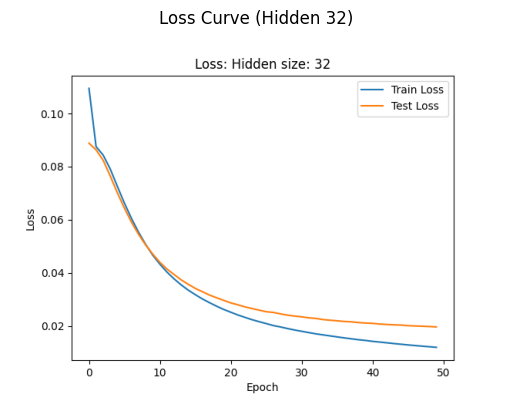

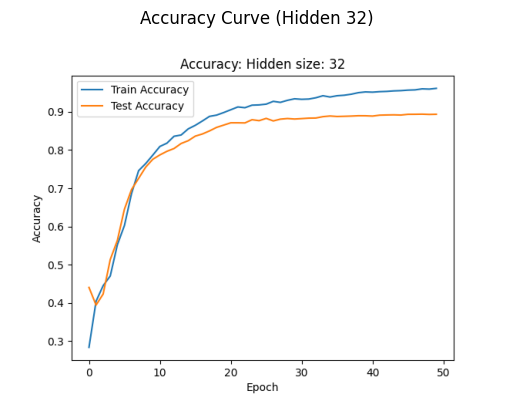

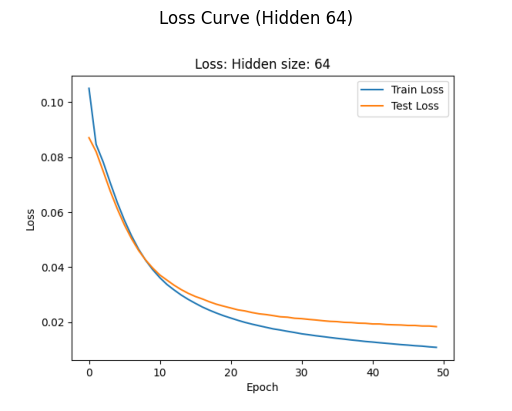

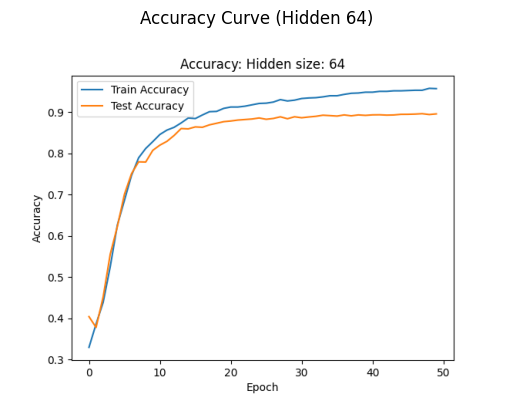

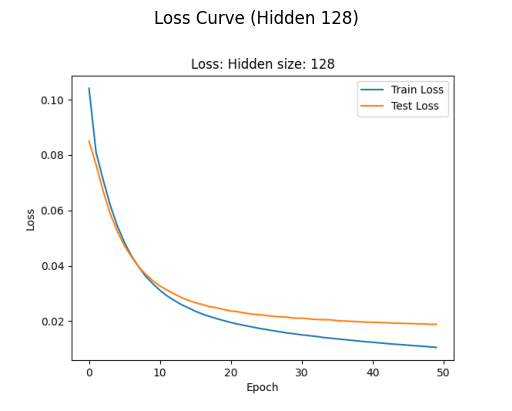

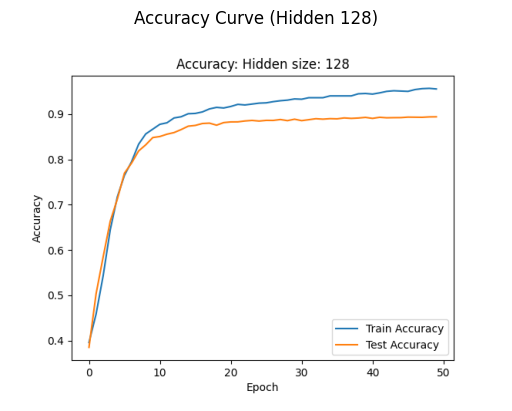

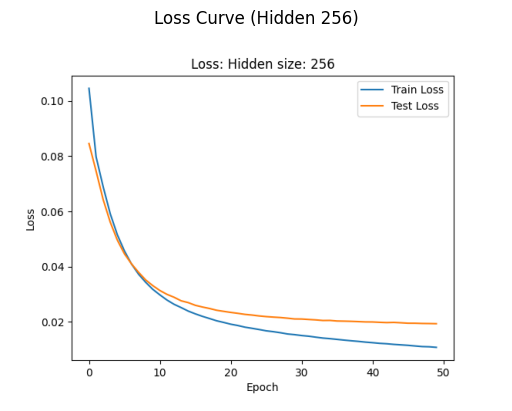

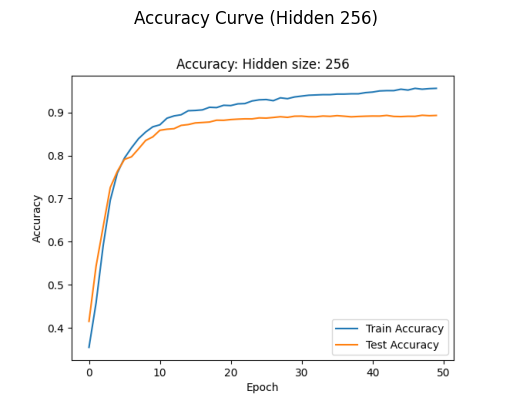

In [15]:
# Listing 5: Optional plot display
from PIL import Image
import matplotlib.pyplot as plt

for h in hidden_sizes:
    loss_img = Image.open(f'plots/loss_hidden_{h}.png')
    acc_img = Image.open(f'plots/acc_hidden_{h}.png')

    plt.figure()
    plt.imshow(loss_img)
    plt.axis('off')
    plt.title(f'Loss Curve (Hidden {h})')
    plt.show()

    plt.figure()
    plt.imshow(acc_img)
    plt.axis('off')
    plt.title(f'Accuracy Curve (Hidden {h})')
    plt.show()


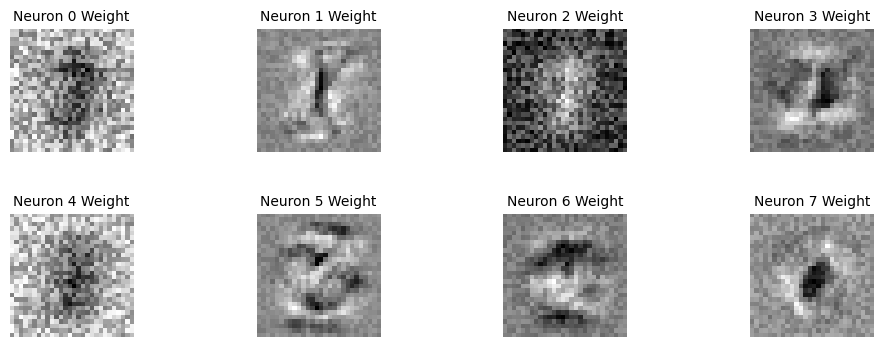

In [16]:
# Listing 6: Visualizing first layer weights
import matplotlib.pyplot as plt

hidden_size = 8  # or another from the list
model = MLP(hidden_size=hidden_size).to(device)
model.load_state_dict(torch.load(f'mlp_hidden_{hidden_size}.pth'))

images = [model.layer_1.weight[i].detach().reshape(28, 28).cpu().numpy()
          for i in range(model.layer_1.weight.shape[0])]

n_rows, n_cols = 2, len(images) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))
axes = axes.flatten()

for i, (ax, image) in enumerate(zip(axes, images)):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Neuron {i} Weight', fontsize=10)
    ax.axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()




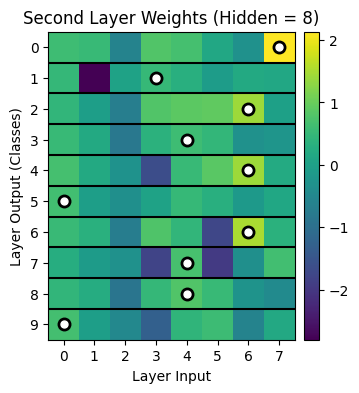

In [17]:
# Listing 7: Visualizing second layer weights
import matplotlib.pyplot as plt

model = MLP(hidden_size=8).to(device)
model.load_state_dict(torch.load(f'mlp_hidden_{8}.pth'))

weights = model.layer_2.weight.detach().cpu()

fig = plt.figure(figsize=(6, 4))
im = plt.imshow(weights, aspect='equal')

plt.xticks(ticks=range(weights.shape[1]))
plt.yticks(ticks=range(weights.shape[0]))

for y in range(1, weights.shape[0]):
    plt.axhline(y - 0.5, color='black', linewidth=1.5)

for y, row in enumerate(weights):
    x = row.argmax().item()
    plt.plot(x, y, 'o', color='black', markersize=9)
    plt.plot(x, y, 'o', color='white', markersize=5)

plt.colorbar(im, shrink=1, pad=0.02)
plt.ylabel('Layer Output (Classes)')
plt.xlabel('Layer Input')
plt.title('Second Layer Weights (Hidden = 8)')
plt.show()
